In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [3]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [4]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

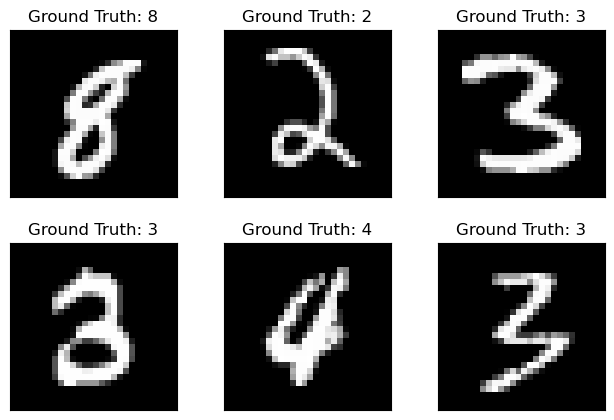

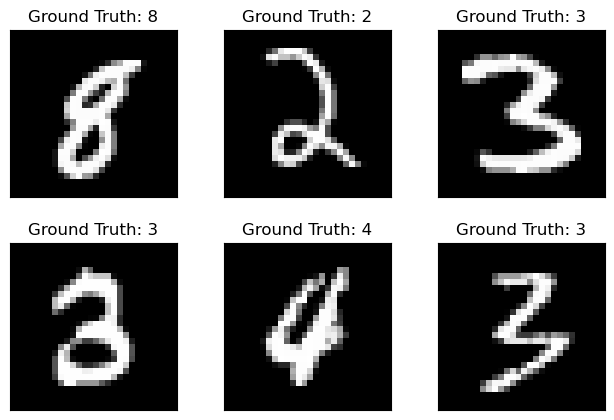

In [6]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)


import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [27]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  
        self.fc2 = nn.Linear(128, 64)       
        self.fc3 = nn.Linear(64, 10)        

    def forward(self, x):
        x = x.view(-1, 28 * 28)  
        x = torch.relu(self.fc1(x))  
        x = torch.relu(self.fc2(x))  
        x = self.fc3(x)  
        return F.softmax(x, dim=1)


In [28]:
# Initialize the model
network = FNN()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [29]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]


In [30]:

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      # torch.save(network.state_dict(), '/results/model.pth')
      # torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [31]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [32]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()


Test set: Avg. loss: -0.0994, Accuracy: 983/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: -0.098047
Train Epoch: 1 [640/60000 (1%)]	Loss: -0.099322
Train Epoch: 1 [1280/60000 (2%)]	Loss: -0.099663
Train Epoch: 1 [1920/60000 (3%)]	Loss: -0.100413
Train Epoch: 1 [2560/60000 (4%)]	Loss: -0.099095
Train Epoch: 1 [3200/60000 (5%)]	Loss: -0.101701
Train Epoch: 1 [3840/60000 (6%)]	Loss: -0.100087
Train Epoch: 1 [4480/60000 (7%)]	Loss: -0.102609
Train Epoch: 1 [5120/60000 (9%)]	Loss: -0.103179
Train Epoch: 1 [5760/60000 (10%)]	Loss: -0.104657
Train Epoch: 1 [6400/60000 (11%)]	Loss: -0.103549
Train Epoch: 1 [7040/60000 (12%)]	Loss: -0.105122
Train Epoch: 1 [7680/60000 (13%)]	Loss: -0.107153
Train Epoch: 1 [8320/60000 (14%)]	Loss: -0.104179
Train Epoch: 1 [8960/60000 (15%)]	Loss: -0.106206
Train Epoch: 1 [9600/60000 (16%)]	Loss: -0.111094
Train Epoch: 1 [10240/60000 (17%)]	Loss: -0.105220
Train Epoch: 1 [10880/60000 (18%)]	Loss: -0.107995
Train Epoch: 1 [11520/60000 (19%)]	Loss: -0.106877
Tr

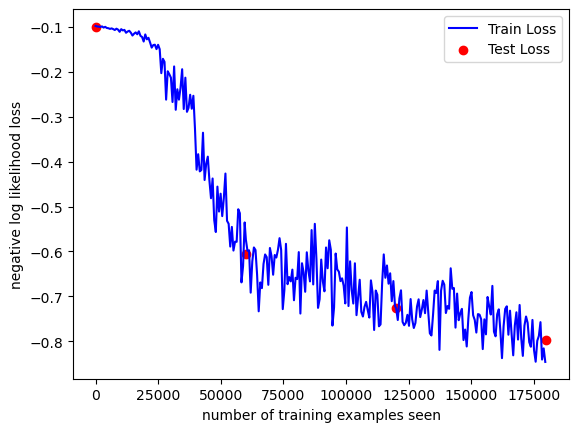

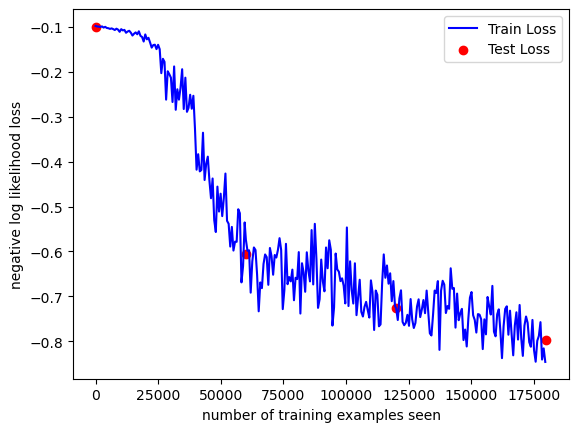

In [33]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

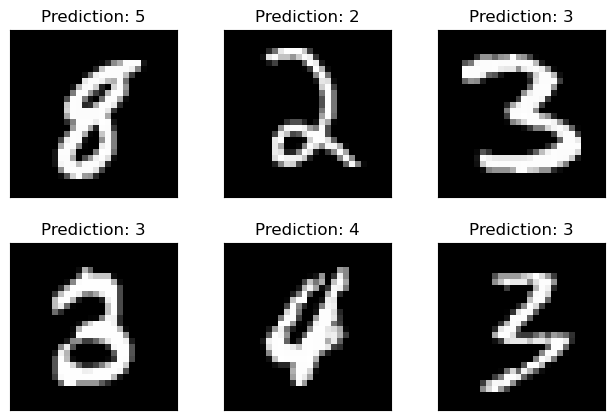

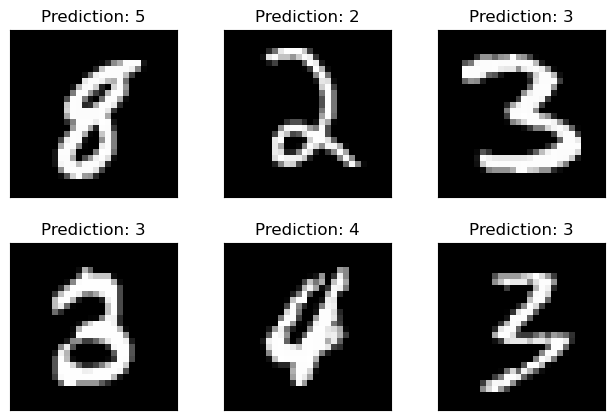

In [34]:
with torch.no_grad():
  output = network(example_data)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig